# DESC Lamp demo 
## Catalog extraction
This notebook shows how to pull postage stamps to use for strong gravitaional lens searches.

# DC2: Generate Postage Stamps (Cutouts) for objects in the Object Catalog

Owner: **Rémy Joseph** ([@herjy](https://github.com/herjy/DESC-Lamp))
<br>Last Verified to Run: **2021-11-22** (by @herjy)

This notebook is partly based on the `dm_butler_postage_stamps_for_object_catalogs` notebook by Yao-Yuan Mao and the previous notebooks `dm_butler_postage_stamps` notebook by Michael Wood-Vasey and the Stack Club `ButlerTutorial` by Daniel Perrefort.

Light curve extraction follows the `dia_sn_vs_truth` notebook by Michael Wood-Vasey.

Here we simply copy what was in Yao-Yuan's notebook and trim it to the usecase of selecting galaxies from cosmoDC2 catalogs with magnitude cuts. The notebook will in fine evolve to incorporate the functions we design to streamline this preselection process.

### Logistics
This is intended to be runnable at NERSC through the https://jupyter.nersc.gov interface from a local git clone of https://github.com/herjy/DESC-Lamp in your NERSC directory.  But you can also run it wherever, with appropriate adjustment of the 'repo' location to point to a place where you have a Butler repo will all of the images. 

This notebook uses the `desc-stack-weekly-latest` kernel. Instructions for setting up the proper DESC python kernel can be found here: https://confluence.slac.stanford.edu/x/o5DVE

## Set up

First we will load the needed modules and DC2 DR6 data sets: object catalogs (with `GCRCatalogs`) and DRP products (with `desc_dc2_dm_data`).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("/home/alxogm/notebooks/alxogm/psf_lensing/DESC-Lamp/")
from desclamp import postage
import galsim
import pickle
# A few common packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import lsst.afw.display.rgb as rgb

We will be using the DC2 Run 2.2i DR6 v2 data. The catalogs and there validation are described here: https://arxiv.org/pdf/2110.03769.pdf


In [3]:
#dc2_data_version = "2.2i_dr6"
#GCRCatalogs.get_available_catalogs(names_only=True, name_contains=dc2_data_version)
#cat = GCRCatalogs.load_catalog("dc2_object_run"+dc2_data_version)
#diaSrc = GCRCatalogs.load_catalog('dc2_dia_source_run1.2p_test')
#diaObject = GCRCatalogs.load_catalog('dc2_dia_object_run1.2p_test')
#truth_lc = GCRCatalogs.load_catalog('dc2_truth_run2.2i_sn_truth_summary')

In [4]:
lampion = postage.Candidates(config="dp02",collection='2.2i/runs/DP0.2')

All the catalog names (including old catalogs) can be found by uncommenting the line below.
Information obout these catalogs can be found in the [DC2 data product overview](https://confluence.slac.stanford.edu/display/LSSTDESC/DC2+Data+Product+Overview). The Rubin project's [Data product definition document](https://docushare.lsstcorp.org/docushare/dsweb/Get/LSE-163/LSE-163_DataProductsDefinitionDocumentDPDD.pdf)(DPDD) provides further insight into the content of these catalogs. 

These are [GCR catalogs](https://github.com/LSSTDESC/gcr-catalogs) that may use slightly different definitions and namings than the one used in Rubin's DPDD. The details for the entries of these catalogs can be found in the [GCR Catalogs SChema description](https://github.com/LSSTDESC/gcr-catalogs/blob/master/GCRCatalogs/SCHEMA.md#schema-for-dc2-object-catalogs)

In [5]:
#print('\n'.join(sorted(GCRCatalogs.get_available_catalogs(include_default_only=False))))

## Select a sample of galaxies based on selection criteria

Here we will use arbitrary (actually from [Rojas et al. 2021](https://arxiv.org/pdf/2109.00014.pdf)) selection criteria to extract a few moock patches.

To learn what columns are in the object catalogs, refer to [this schema table](https://github.com/LSSTDESC/gcr-catalogs/blob/master/GCRCatalogs/SCHEMA.md#schema-for-dc2-object-catalogs). And sometimes it'd be helpful to look at the [source code](https://github.com/LSSTDESC/gcr-catalogs/blob/master/GCRCatalogs/dc2_object.py#L341).

bright_galaxy_query = ("clean",
    "extendedness == 1",
    "mag_g_cModel- mag_i_cModel < 5",
    "mag_g_cModel- mag_i_cModel > 1.8",
    "mag_g_cModel- mag_r_cModel < 3",
    "mag_g_cModel- mag_r_cModel > 0.6",
    "mag_r_cModel < 22.5",
    "mag_r_cModel > 18",
    "mag_g_cModel > 20",
    "mag_i_cModel > 18.2",
    "snr_g_cModel > 10",
    "snr_r_cModel > 10",
    "snr_i_cModel > 10",
    )

objects = lampion.catalog_query(bright_galaxy_query, tracts=[4639])
print(f"The query returned {len(objects['tract'])} results. Let's not display them all")

In [6]:
use_center_coords = "62, -37"
use_radius = "1.0"

bright_galaxy_query = "SELECT objectId, detect_isPrimary, " + \
        "coord_ra AS ra, coord_dec AS dec, tract, patch,  " + \
        "scisql_nanojanskyToAbMag(g_cModelFlux) AS mag_g_cModel, " + \
        "scisql_nanojanskyToAbMag(r_cModelFlux) AS mag_r_cModel, " + \
        "scisql_nanojanskyToAbMag(i_cModelFlux) AS mag_i_cModel, " + \
        "refExtendedness " + \
        "FROM dp02_dc2_catalogs.Object " + \
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), " + \
        "CIRCLE('ICRS', " + use_center_coords + ", " + use_radius + ")) = 1 " + \
        "AND detect_isPrimary = 1 " + \
        "AND scisql_nanojanskyToAbMag(g_cModelFlux) - scisql_nanojanskyToAbMag(i_cModelFlux) < 5.0 " + \
        "AND scisql_nanojanskyToAbMag(g_cModelFlux) - scisql_nanojanskyToAbMag(i_cModelFlux) > 1.8 " + \
        "AND scisql_nanojanskyToAbMag(g_cModelFlux) - scisql_nanojanskyToAbMag(r_cModelFlux) < 3.0 " + \
        "AND scisql_nanojanskyToAbMag(g_cModelFlux) - scisql_nanojanskyToAbMag(r_cModelFlux) > 0.6 " + \
        "AND scisql_nanojanskyToAbMag(r_cModelFlux) < 22.5 " + \
        "AND scisql_nanojanskyToAbMag(r_cModelFlux) > 18.0 " + \
        "AND scisql_nanojanskyToAbMag(g_cModelFlux) > 20.0 " + \
        "AND scisql_nanojanskyToAbMag(i_cModelFlux) > 18.2 " + \
        "AND refExtendedness IS NOT NULL " + \
        "AND refExtendedness = 1 "

In [7]:
object_file="galaxies.csv"
if  os.path.isfile(object_file):
    objects=pd.read_csv(object_file)
else:
    objects = lampion.catalog_query(bright_galaxy_query)

print(f"The query returned {len(objects)} results. Let's not display them all")

The query returned 15134 results. Let's not display them all


In [8]:
objects

,Unnamed: 0,objectId,ra,dec,tract,patch
0,0,1568246628836490097,62.541629,-37.852021,3638,27
1,1,1568246628836489742,62.502890,-37.854683,3638,27
2,2,1568246628836489878,62.598000,-37.853360,3638,27
3,3,1568246628836489828,62.636166,-37.848589,3638,27
4,4,1568246628836490224,62.554018,-37.849878,3638,27
...,...,...,...,...,...,...
15129,15129,1651457668826564108,62.372455,-36.259943,3831,30
15130,15130,1651457668826573065,62.531908,-36.166372,3831,30
15131,15131,1651457668826573333,62.411500,-36.162118,3831,30
15132,15132,1651457668826573334,62.409845,-36.160947,3831,30


## Extracting postage stamps

Now we need to extract postage stamps of the coadded images. For that we need for each object there coordinates, but also there tact and patch number.

In [10]:
file = open('lensed_source_2','rb')
lensed_source = pickle.load(file, encoding='bytes')
gsobj = galsim.Image(lensed_source)

In [11]:
i = 0 #int(np.random.rand(1)*9000)
cutouts = lampion.make_postage_stamps(objects.loc[i:i+10], cutout_size=100, bands = 'irg')

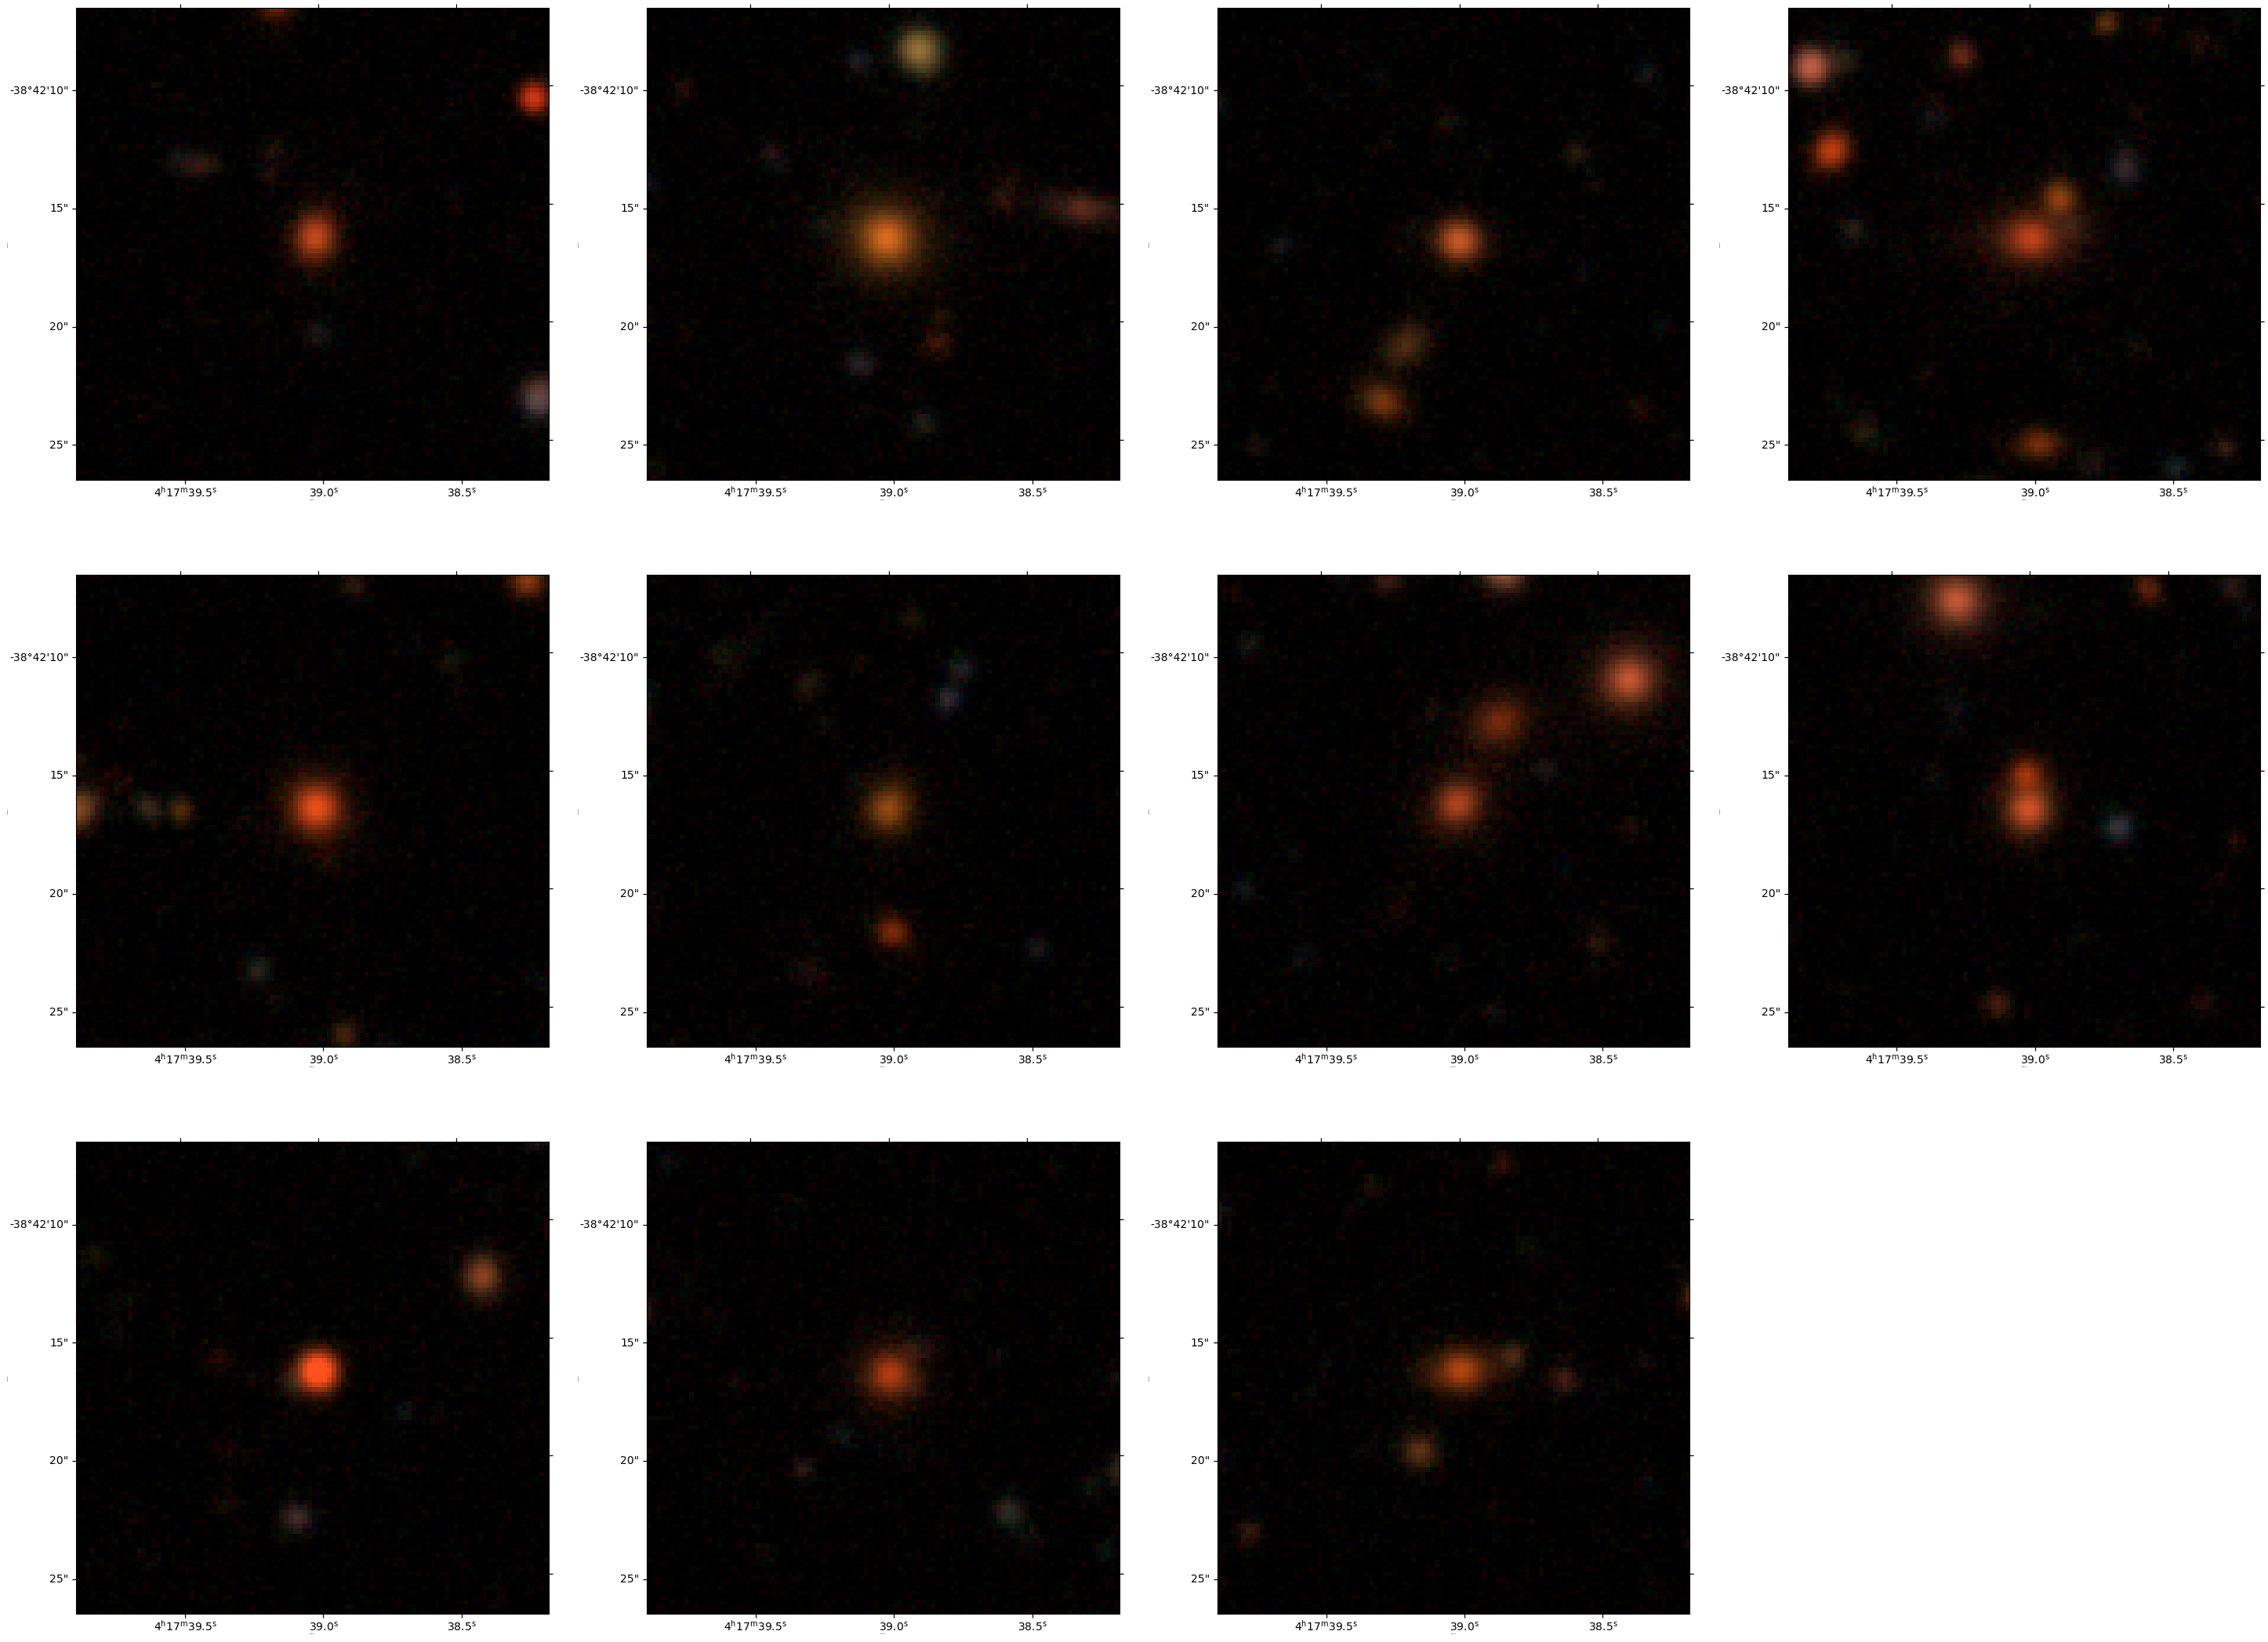

In [12]:
lampion.display_cutouts(cutouts, cutout_size=45)

0## Insert lensed sources and display

In [14]:
injectec_cutouts=[cutout.inject(gsobj, (200,250,250)) for cutout in cutouts]

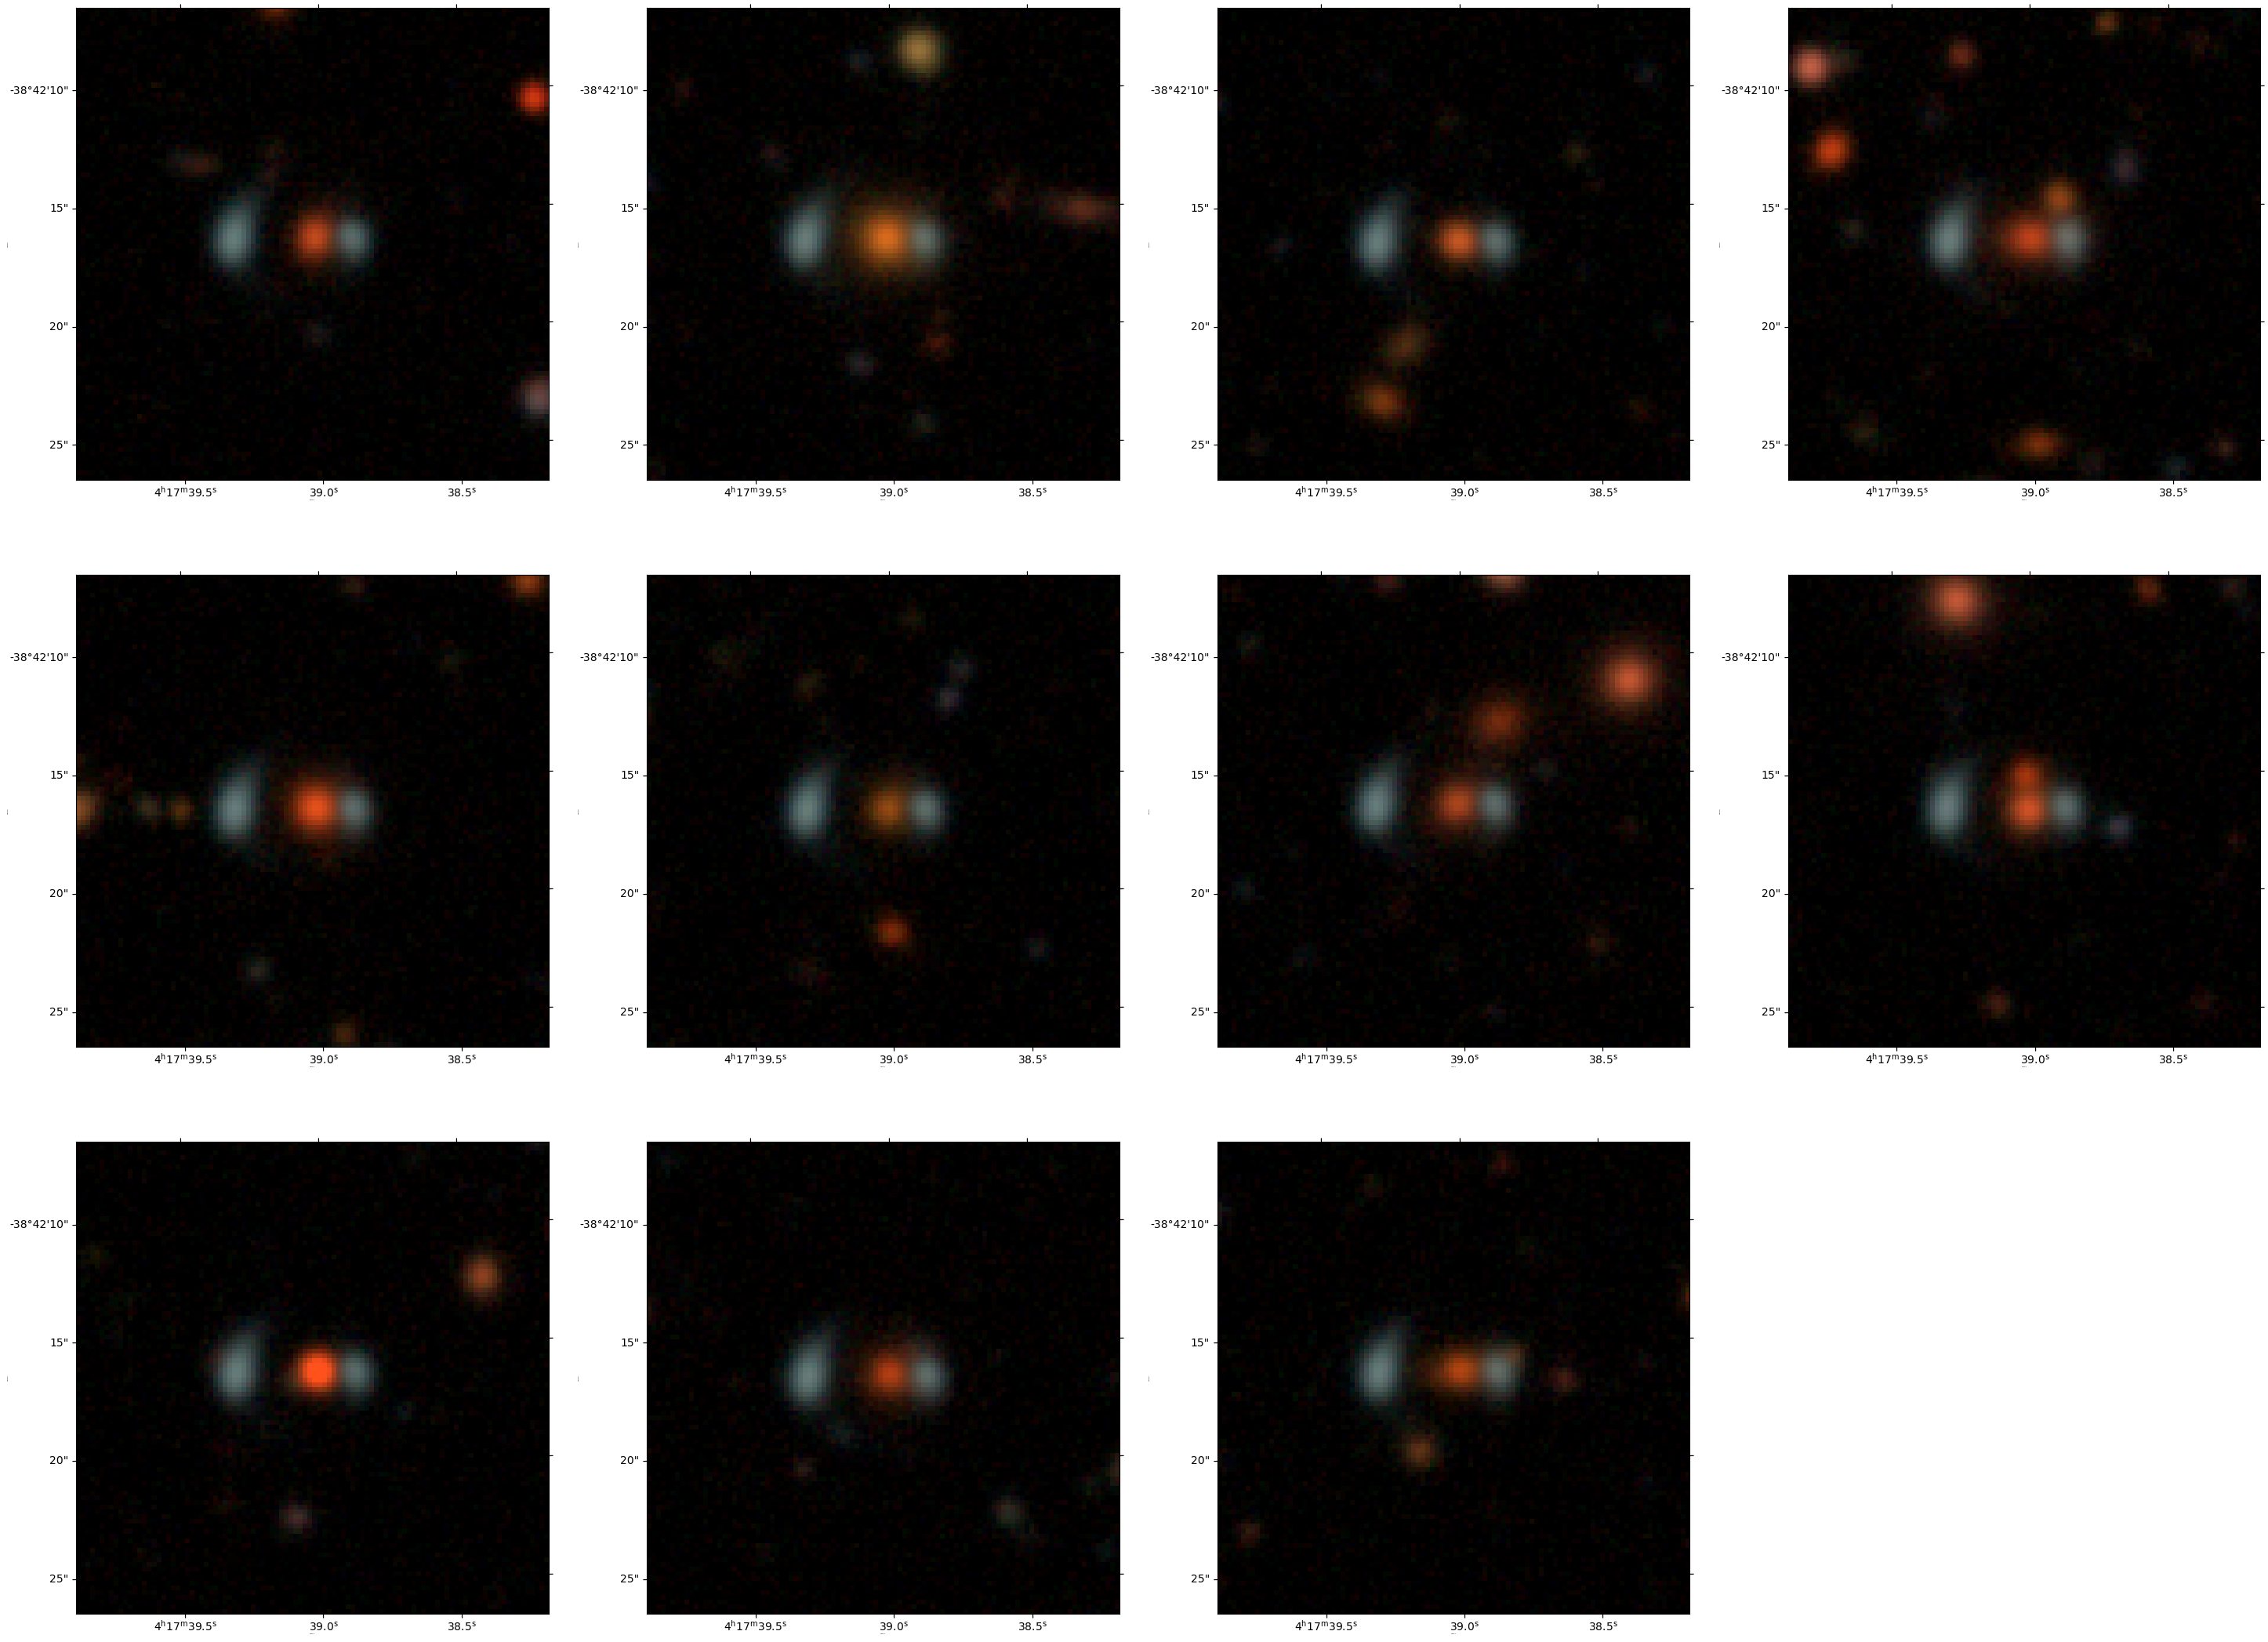

In [15]:
lampion.display_cutouts(injectec_cutouts, cutout_size=45)

In [16]:
#DEBLEND OBJECTS. 

In [17]:
import lsst.daf.base as dafBase
import lsst.afw.display as afwDisplay
import lsst.afw.table as afwTable

In [18]:
# Pipeline tasks
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask
from lsst.meas.algorithms.detection import SourceDetectionTask
from lsst.meas.deblender import SourceDeblendTask
from lsst.meas.base import SingleFrameMeasurementTask

In [19]:
plt.style.use('tableau-colorblind10')
afwDisplay.setDefaultBackend('matplotlib')
plt.rcParams['figure.figsize'] = (8.0, 8.0)

In [20]:
# Create a basic schema to use with these tasks
schema = afwTable.SourceTable.makeMinimalSchema()
print(schema)

# Create a container which will be used to record metadata
#  about algorithm execution
algMetadata = dafBase.PropertyList()
print('algMetadata: ')
algMetadata

Schema(
    (Field['L'](name="id", doc="unique ID"), Key<L>(offset=0, nElements=1)),
    (Field['Angle'](name="coord_ra", doc="position in ra/dec"), Key<Angle>(offset=8, nElements=1)),
    (Field['Angle'](name="coord_dec", doc="position in ra/dec"), Key<Angle>(offset=16, nElements=1)),
    (Field['L'](name="parent", doc="unique ID of parent source"), Key<L>(offset=24, nElements=1)),
)

algMetadata: 


In [21]:
coaad=injectec_cutouts[0].exposure[0]

In [22]:
coaad.image

lsst.afw.image._image.ImageF=[[ 0.05699168  0.01741114 -0.04410917 ... -0.02992452  0.00110807
   0.03280997]
 [ 0.09537985  0.09955166  0.09041046 ... -0.12327991  0.02469516
   0.09157173]
 [ 0.04534724  0.04181782 -0.04627104 ...  0.00691453  0.08026242
  -0.10856538]
 ...
 [-0.07458549 -0.0344409   0.015793   ... -0.0128708   0.09610553
   0.02686941]
 [-0.04249077 -0.13629025 -0.03526204 ...  0.00197093  0.05409727
  -0.01526374]
 [ 0.03196844  0.10021171  0.02741377 ...  0.04855447 -0.02202761
  -0.0640071 ]], bbox=(minimum=(26429, 15363), maximum=(26528, 15462))

In [23]:
# Unset the `DETECTED` bits of the mask plane
coaad.mask.removeAndClearMaskPlane('DETECTED')

<Figure size 800x800 with 0 Axes>

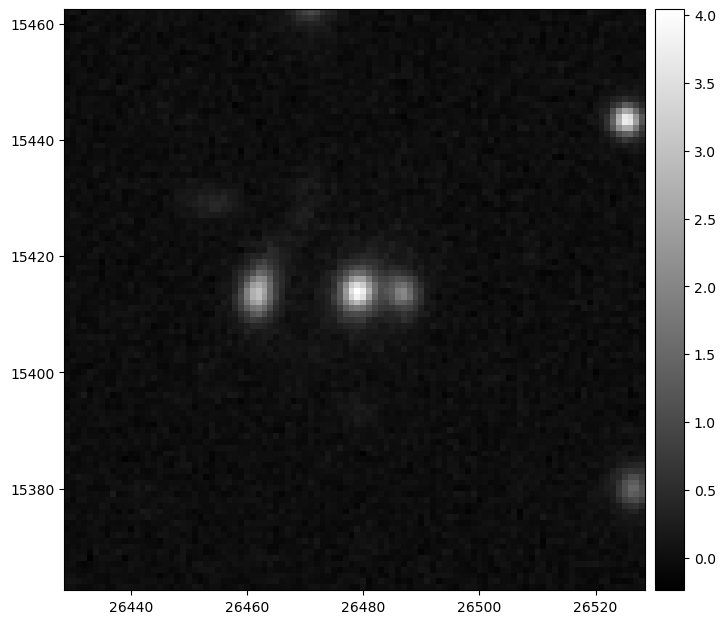

In [24]:
plt.figure()
afw_display = afwDisplay.Display()
#afw_display.scale('asinh', 'zscale')
afw_display.mtv(coaad.image)

In [25]:
# Characterize the image properties
config = CharacterizeImageTask.ConfigClass()
config.psfIterations = 1
charImageTask = CharacterizeImageTask(config=config)

# Detect sources
config = SourceDetectionTask.ConfigClass()
# detection threshold in units of thresholdType
config.thresholdValue = 10
# units for thresholdValue
config.thresholdType = "stdev"
sourceDetectionTask = SourceDetectionTask(schema=schema, config=config)

# Deblend sources
sourceDeblendTask = SourceDeblendTask(schema=schema)

# Measure source properties
config = SingleFrameMeasurementTask.ConfigClass()
sourceMeasurementTask = SingleFrameMeasurementTask(schema=schema,
                                                   config=config,
                                                   algMetadata=algMetadata)

In [26]:
tab = afwTable.SourceTable.make(schema)

In [27]:
# Source detection (this cell may take a few seconds)
result = sourceDetectionTask.run(tab, coaad)
type(result)

lsst.pipe.base.struct.Struct

In [28]:
for k, v in result.getDict().items():
    print(k, type(v))

positive <class 'lsst.afw.detection.FootprintSet'>
negative <class 'NoneType'>
factor <class 'float'>
factorNeg <class 'float'>
positiveThreshold <class 'lsst.afw.detection.Threshold'>
negativeThreshold <class 'lsst.afw.detection.Threshold'>
background <class 'lsst.afw.math._backgroundList.BackgroundList'>
numPos <class 'int'>
numPosPeaks <class 'int'>
numNeg <class 'int'>
numNegPeaks <class 'int'>
sources <class 'lsst.afw.table.SourceCatalog'>


In [29]:
result.numPosPeaks

7

In [30]:
sources = result.sources

In [31]:
# Source deblending
sourceDeblendTask.run(coaad, sources)

# Source measurement
sourceMeasurementTask.run(measCat=sources, exposure=coaad)

In [32]:
# The copy makes sure that the sources are sequential in memory
sources = sources.copy(True)

# Investigate the output source catalog
sources.asAstropy()

id,coord_ra,coord_dec,parent,deblend_nChild,deblend_deblendedAsPsf,deblend_psfCenter_x,deblend_psfCenter_y,deblend_psf_instFlux,deblend_tooManyPeaks,deblend_parentTooBig,deblend_masked,deblend_failed,deblend_skipped,deblend_rampedTemplate,deblend_patchedTemplate,deblend_hasStrayFlux,deblend_peak_center_x,deblend_peak_center_y,deblend_peakId,deblend_nPeaks,deblend_parentNPeaks,base_NaiveCentroid_x,base_NaiveCentroid_y,base_NaiveCentroid_flag,base_NaiveCentroid_flag_noCounts,base_NaiveCentroid_flag_edge,base_NaiveCentroid_flag_resetToPeak,base_SdssCentroid_x,slot_Centroid_x,base_SdssCentroid_y,slot_Centroid_y,base_SdssCentroid_xErr,slot_Centroid_xErr,base_SdssCentroid_yErr,slot_Centroid_yErr,base_SdssCentroid_flag,base_CircularApertureFlux_flag_badCentroid,base_GaussianFlux_flag_badCentroid,base_LocalBackground_flag_badCentroid,base_NaiveCentroid_flag_badInitialCentroid,base_PsfFlux_flag_badCentroid,base_SdssShape_flag_badCentroid,base_Variance_flag_badCentroid,slot_Centroid_flag,base_SdssCentroid_flag_edge,base_CircularApertureFlux_flag_badCentroid_edge,base_GaussianFlux_flag_badCentroid_edge,base_LocalBackground_flag_badCentroid_edge,base_NaiveCentroid_flag_badInitialCentroid_edge,base_PsfFlux_flag_badCentroid_edge,base_SdssShape_flag_badCentroid_edge,base_Variance_flag_badCentroid_edge,slot_Centroid_flag_edge,base_SdssCentroid_flag_noSecondDerivative,base_CircularApertureFlux_flag_badCentroid_noSecondDerivative,base_GaussianFlux_flag_badCentroid_noSecondDerivative,base_LocalBackground_flag_badCentroid_noSecondDerivative,base_NaiveCentroid_flag_badInitialCentroid_noSecondDerivative,base_PsfFlux_flag_badCentroid_noSecondDerivative,base_SdssShape_flag_badCentroid_noSecondDerivative,base_Variance_flag_badCentroid_noSecondDerivative,slot_Centroid_flag_noSecondDerivative,base_SdssCentroid_flag_almostNoSecondDerivative,base_CircularApertureFlux_flag_badCentroid_almostNoSecondDerivative,base_GaussianFlux_flag_badCentroid_almostNoSecondDerivative,base_LocalBackground_flag_badCentroid_almostNoSecondDerivative,base_NaiveCentroid_flag_badInitialCentroid_almostNoSecondDerivative,base_PsfFlux_flag_badCentroid_almostNoSecondDerivative,base_SdssShape_flag_badCentroid_almostNoSecondDerivative,base_Variance_flag_badCentroid_almostNoSecondDerivative,slot_Centroid_flag_almostNoSecondDerivative,base_SdssCentroid_flag_notAtMaximum,base_CircularApertureFlux_flag_badCentroid_notAtMaximum,base_GaussianFlux_flag_badCentroid_notAtMaximum,base_LocalBackground_flag_badCentroid_notAtMaximum,base_NaiveCentroid_flag_badInitialCentroid_notAtMaximum,base_PsfFlux_flag_badCentroid_notAtMaximum,base_SdssShape_flag_badCentroid_notAtMaximum,base_Variance_flag_badCentroid_notAtMaximum,slot_Centroid_flag_notAtMaximum,base_SdssCentroid_flag_near_edge,base_CircularApertureFlux_flag_badCentroid_near_edge,base_GaussianFlux_flag_badCentroid_near_edge,base_LocalBackground_flag_badCentroid_near_edge,base_NaiveCentroid_flag_badInitialCentroid_near_edge,base_PsfFlux_flag_badCentroid_near_edge,base_SdssShape_flag_badCentroid_near_edge,base_Variance_flag_badCentroid_near_edge,slot_Centroid_flag_near_edge,base_SdssCentroid_flag_resetToPeak,base_CircularApertureFlux_flag_badCentroid_resetToPeak,base_GaussianFlux_flag_badCentroid_resetToPeak,base_LocalBackground_flag_badCentroid_resetToPeak,base_NaiveCentroid_flag_badInitialCentroid_resetToPeak,base_PsfFlux_flag_badCentroid_resetToPeak,base_SdssShape_flag_badCentroid_resetToPeak,base_Variance_flag_badCentroid_resetToPeak,slot_Centroid_flag_resetToPeak,base_SdssCentroid_flag_badError,base_CircularApertureFlux_flag_badCentroid_badError,base_GaussianFlux_flag_badCentroid_badError,base_LocalBackground_flag_badCentroid_badError,base_NaiveCentroid_flag_badInitialCentroid_badError,base_PsfFlux_flag_badCentroid_badError,base_SdssShape_flag_badCentroid_badError,base_Variance_flag_badCentroid_badError,slot_Centroid_flag_badError,base_Blendedness_old,base_Blendedness_raw,base_Blendedness_raw_child_instFlux,base_Blendedness_raw_parent_instFl

<Figure size 800x800 with 0 Axes>

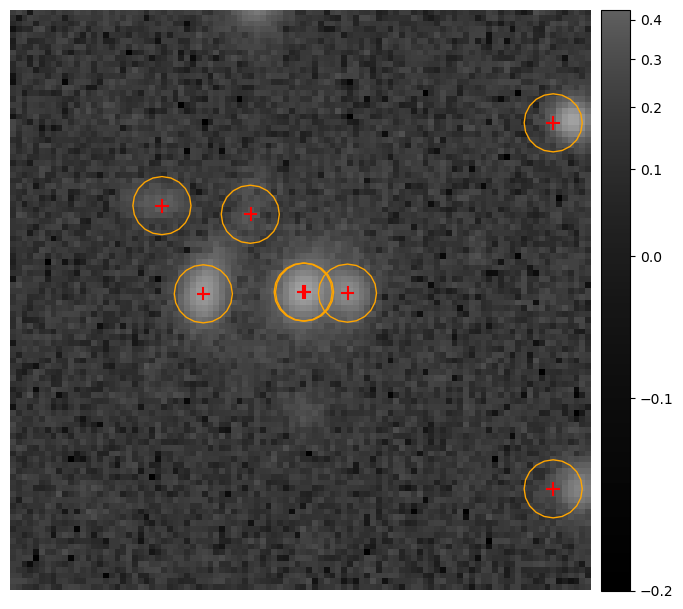

In [33]:
# Display the cutout and sources with afw display
image = coaad.image
plt.figure()
afw_display = afwDisplay.Display()
afw_display.scale('asinh', 'zscale')
afw_display.mtv(image)
plt.gca().axis('off')

# We use display buffering to avoid re-drawing the image
#  after each source is plotted
with afw_display.Buffering():
    for s in sources:
        afw_display.dot('+', s.getX(), s.getY(), size=1,ctype=afwDisplay.RED)
        afw_display.dot('o', s.getX(), s.getY(), size=5, ctype='orange')